# **Download Dataset**

### **download data from Kaggle**

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Replace 'dataset-name' with the actual name of the dataset
!kaggle datasets download -d  pavansanagapati/images-dataset

 99% 1.01G/1.01G [00:14<00:00, 73.3MB/s]
100% 1.01G/1.01G [00:14<00:00, 75.7MB/s]


OR you can get this kaggle dataset from this link.[https://www.kaggle.com/datasets/pavansanagapati/images-dataset]

In [ ]:
# Unzip the downloaded file
!unzip -q images-dataset.zip -d images-dataset

# **Import Libraries**

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.nn import Sequential, Conv2d, MaxPool2d
from torch.utils.data import Dataset, DataLoader

# **Data Preprocessing**

### **Load Data**

In [ ]:
def find_object_from_directory(dirname):
    match dirname:
        case "/content/images-dataset/data/bike":
            return "bike"
        case "/content/images-dataset/data/cars":
            return "cars"
        case "/content/images-dataset/data/cats":
            return "cats"
        case "/content/images-dataset/data/dogs":
            return "dogs"
        case "/content/images-dataset/data/flowers":
            return "flowers"
        case "/content/images-dataset/data/horses":
            return "horses"
        case "/content/images-dataset/data/human":
            return "human"
        case "/content/images-dataset/data/data/bike":
            return "bike"
        case "/content/images-dataset/data/data/cars":
            return "cars"
        case "/content/images-dataset/data/data/cats":
            return "cats"
        case "/content/images-dataset/data/data/dogs":
            return "dogs"
        case "/content/images-dataset/data/data/flowers":
            return "flowers"
        case "/content/images-dataset/data/data/horses":
            return "horses"
        case "/content/images-dataset/data/data/human":
            return "human"
        case _:
            return None

Data loader class to load data

In [ ]:
class CustomDataset(Dataset):
    def __init__(self):
        self.data = []
        for dirname, _, filenames in os.walk('/content/images-dataset'):
            num_dir = find_object_from_directory(dirname)
            for filename in filenames:
                self.data.append([os.path.join(dirname, filename),num_dir])

        self.class_map = {"bike" : 0, "cars": 1, "cats": 2, "dogs": 3, "flowers": 4, "horses": 5, "human": 6}
        self.img_dim = (128, 128)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        img = img/255
        img = np.float32(img)
        if img_path[-3:-1] != "pn":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [ ]:
dataset = CustomDataset()
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 128, 128]) tensor([1])


Show sample data

3606
Label : tensor([0])


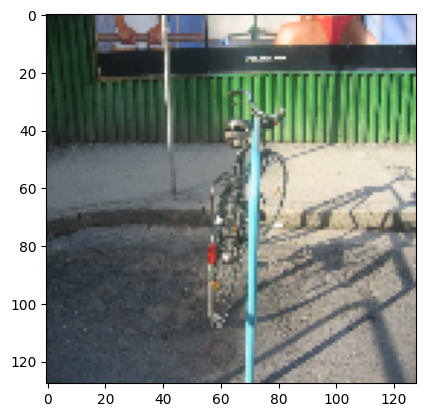

In [ ]:
def display_img(img,label):
    print(f"Label : {label}")
    plt.imshow(img.T)

#display the first image in the dataset
print(len(dataset))
img, label = dataset[2500]
display_img(img,label)

Create train, test & Validation sets

In [ ]:
train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
val_size = len(dataset) - train_size - test_size

# use torch.utils.data.random_split for training/test split
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

# define a loader for the training data we can iterate through in 50-image batches
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=50,
    num_workers=0,
    shuffle=False
)

# define a loader for the testing data we can iterate through in 50-image batches
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=50,
    num_workers=0,
    shuffle=False
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=50,
    num_workers=0,
    shuffle=False
)

# **Neural Network Architecture**

In [ ]:
class Net(nn.Module):

    def __init__(self, num_classes=7):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.pool(self.conv3(x)))
        x = F.relu(self.pool(self.conv4(x)))
        x = F.dropout(self.drop(x), training=self.training)
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)


net = Net()

In [ ]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

In [ ]:
model = Net().to(device)

print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=7, bias=True)
)


# **Model Training**

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with

        n = np.shape(target)[0]
        target_bis = np.zeros((n,7))

        for i in range(n):
            target_bis[i][target[i]] = 1

        target_bis = torch.from_numpy(target_bis)

        data, target = data.to(device), target_bis.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # Get the loss

        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # # Print metrics so we see some progress
        # print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))

    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [ ]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:

            n = np.shape(target)[0]
            target_bis = np.zeros((n,7))

            for i in range(n):
                target_bis[i][target[i]] = 1

            target_bis = torch.from_numpy(target_bis)

            batch_count += 1
            data, target = data.to(device), target_bis.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            _, true_label = torch.max(target.data, 1)
            correct += torch.sum(true_label==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Test set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # return average loss for the epoch
    return avg_loss

In [ ]:
def val(model, device, val_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in val_loader:

            n = np.shape(target)[0]
            target_bis = np.zeros((n,7))

            for i in range(n):
                target_bis[i][target[i]] = 1

            target_bis = torch.from_numpy(target_bis)

            batch_count += 1
            data, target = data.to(device), target_bis.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            _, true_label = torch.max(target.data, 1)
            correct += torch.sum(true_label==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

    # return average loss for the epoch
    return avg_loss

### **Model Training**

In [ ]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 30
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        val_loss = val(model, device, val_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(val_loss)

Training on cpu
Epoch: 1
Training set: Average loss: 1.543865
Test set: Average loss: 1.168694, Accuracy: 317/540 (59%)

Validation set: Average loss: 1.107200, Accuracy: 324/542 (60%)

Epoch: 2
Training set: Average loss: 1.034263
Test set: Average loss: 0.949607, Accuracy: 352/540 (65%)

Validation set: Average loss: 0.855213, Accuracy: 367/542 (68%)

Epoch: 3
Training set: Average loss: 0.847820
Test set: Average loss: 0.766001, Accuracy: 392/540 (73%)

Validation set: Average loss: 0.708987, Accuracy: 405/542 (75%)

Epoch: 4
Training set: Average loss: 0.710772
Test set: Average loss: 0.657650, Accuracy: 405/540 (75%)

Validation set: Average loss: 0.619569, Accuracy: 412/542 (76%)

Epoch: 5
Training set: Average loss: 0.635741
Test set: Average loss: 0.665909, Accuracy: 406/540 (75%)

Validation set: Average loss: 0.619239, Accuracy: 423/542 (78%)

Epoch: 6
Training set: Average loss: 0.593762
Test set: Average loss: 0.553267, Accuracy: 431/540 (80%)

Validation set: Average loss:

### **Training & Validation Loss Curve**

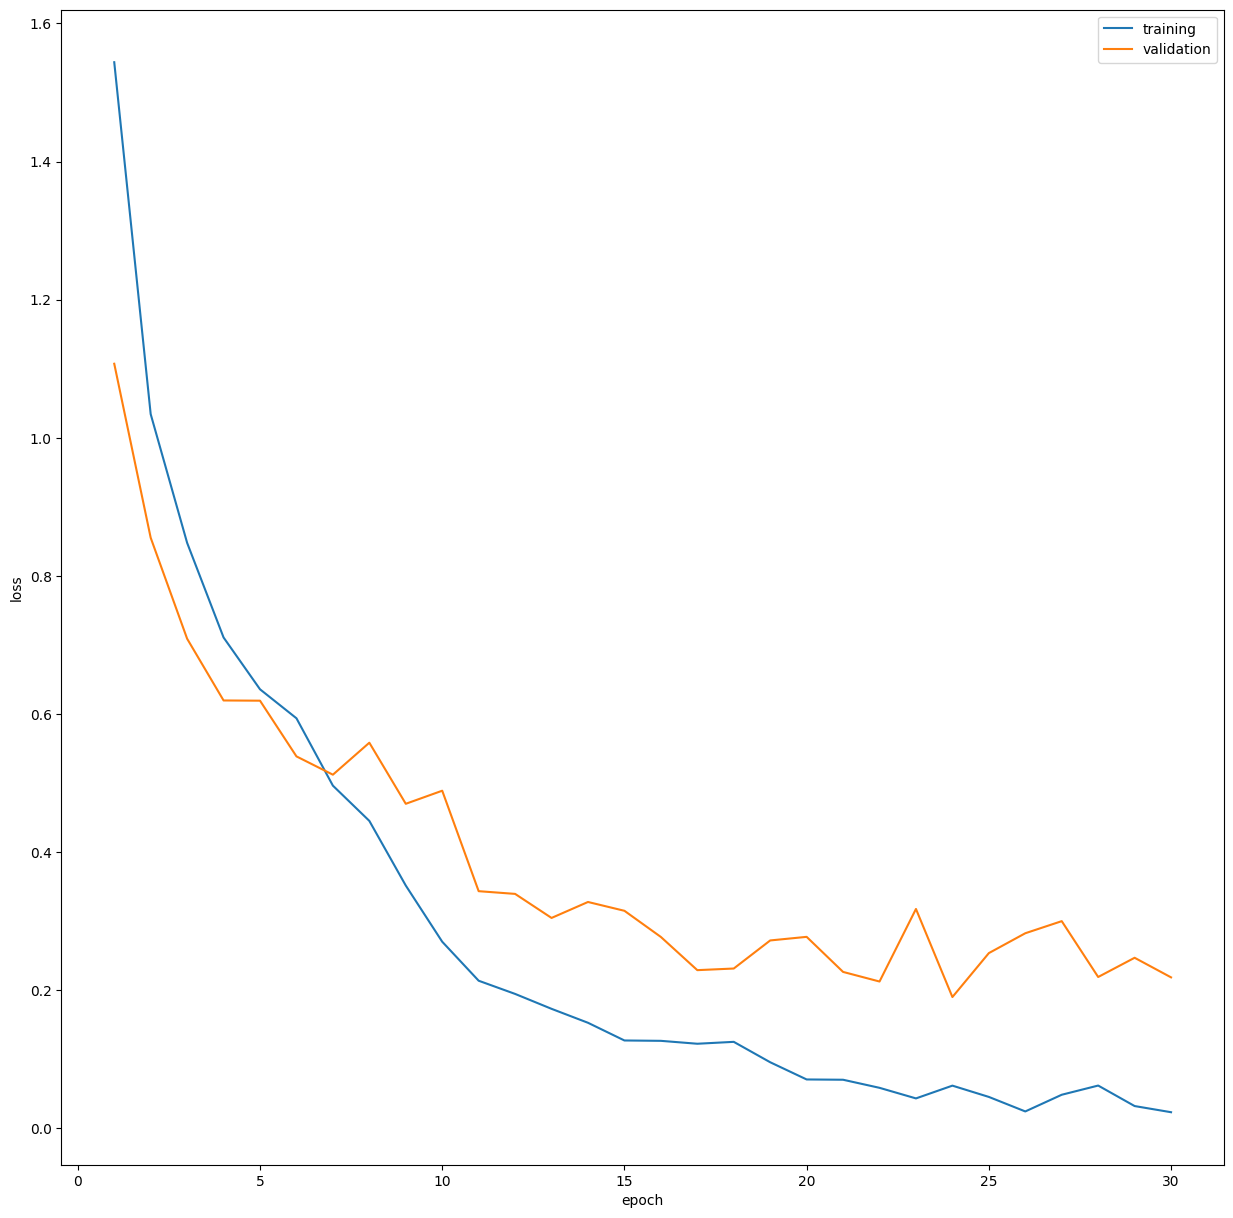

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### **Confusion Matrix Heatmap**

Getting predictions from test set...


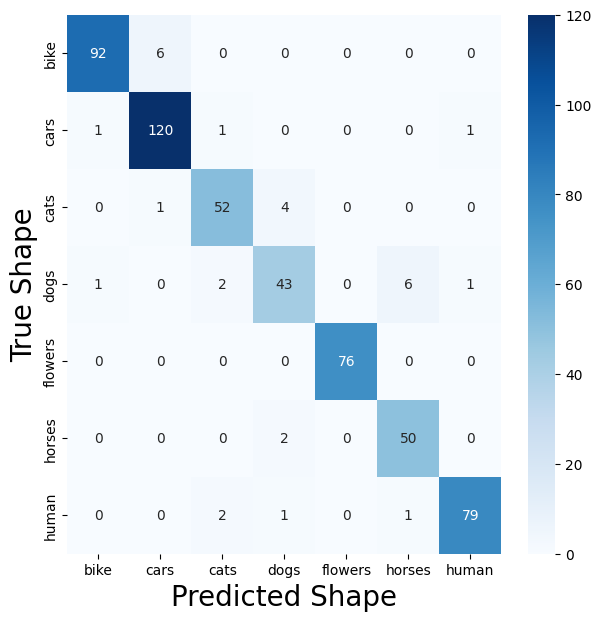

In [ ]:
# Defining Labels and Predictions
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in val_loader:
    data = data.to(device)

    for label in target:
        truelabels.append(label.numpy())
    for prediction in model(data).cpu().argmax(1):
        predictions.append(prediction.numpy())

# Plot the confusion matrix
classes = ['bike','cars','cats','dogs','flowers','horses','human']

cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()

### **Save trained model**

In [ ]:
# Save the trained model
PATH = 'model_95.pth'
torch.save(model.state_dict(), PATH)
print('Model saved at', PATH)

Model saved at model_95.pth


# **Load & Test Model**

In [ ]:
# Save the trained model
PATH = '/content/model_95.pth'

# Load the saved model
loaded_model = Net()  # Use the correct model class (Net) here

# loaded_model.load_state_dict(torch.load(PATH))

# Specify map_location=torch.device('cpu') to load the model on CPU
loaded_model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

loaded_model.eval()  # Set the model to evaluation mode

# Iterate through the test dataset and make predictions
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = loaded_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print("Accuracy:", accuracy*100)

Accuracy: 94.62962962962963


In [ ]:
# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Display classification report
class_report = classification_report(all_labels, all_predictions)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Classification Report:")
print(class_report)

Precision: 0.9479654199618622
Recall: 0.9462962962962963
F1 Score: 0.9457647888139094
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       114
           1       0.96      0.96      0.96       134
           2       0.85      0.95      0.90        64
           3       0.94      0.78      0.85        59
           4       1.00      1.00      1.00        49
           5       0.92      1.00      0.96        61
           6       0.95      0.93      0.94        59

    accuracy                           0.95       540
   macro avg       0.94      0.94      0.94       540
weighted avg       0.95      0.95      0.95       540



### **Feature Maps**

In [ ]:
def get_first_layer_activations(model, input_data):
    activations = []

    def hook_fn(module, input, output):
        activations.append(output)

    hook = model.conv1.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(input_data)

    hook.remove()

    return activations

def show_all_feature_maps(activations):
    # Visualize all feature maps in a grid
    num_feature_maps = first_layer_activations[0].shape[1]
    rows = 4  # You can adjust the number of rows and columns based on the number of feature maps
    cols = num_feature_maps // rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    for i in range(rows):
        for j in range(cols):
            feature_map = first_layer_activations[0][0, i * cols + j].cpu().numpy()
            axes[i, j].imshow(feature_map, cmap='viridis')
            axes[i, j].axis('off')
            axes[i, j].set_title(f'Feature Map {i * cols + j + 1}')

    plt.tight_layout()
    plt.show()

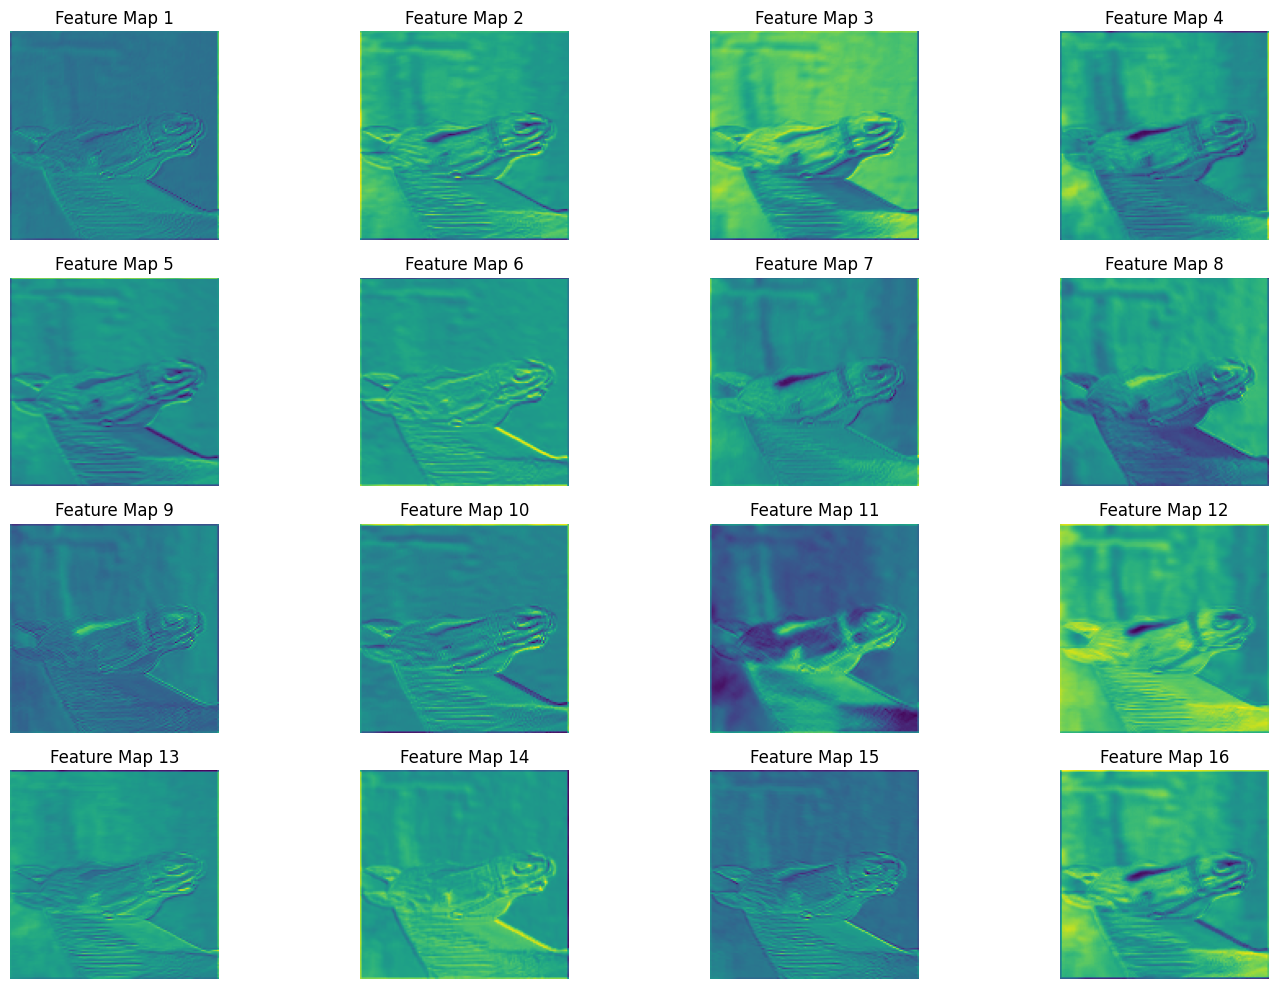

In [ ]:
# Get a sample from the dataset
sample, _ = next(iter(test_loader))

# Get activations of the first layer
first_layer_activations = get_first_layer_activations(loaded_model, sample)

# Show all feature maps of the first layer
show_all_feature_maps(first_layer_activations)


### **Learned Kernal Weights**

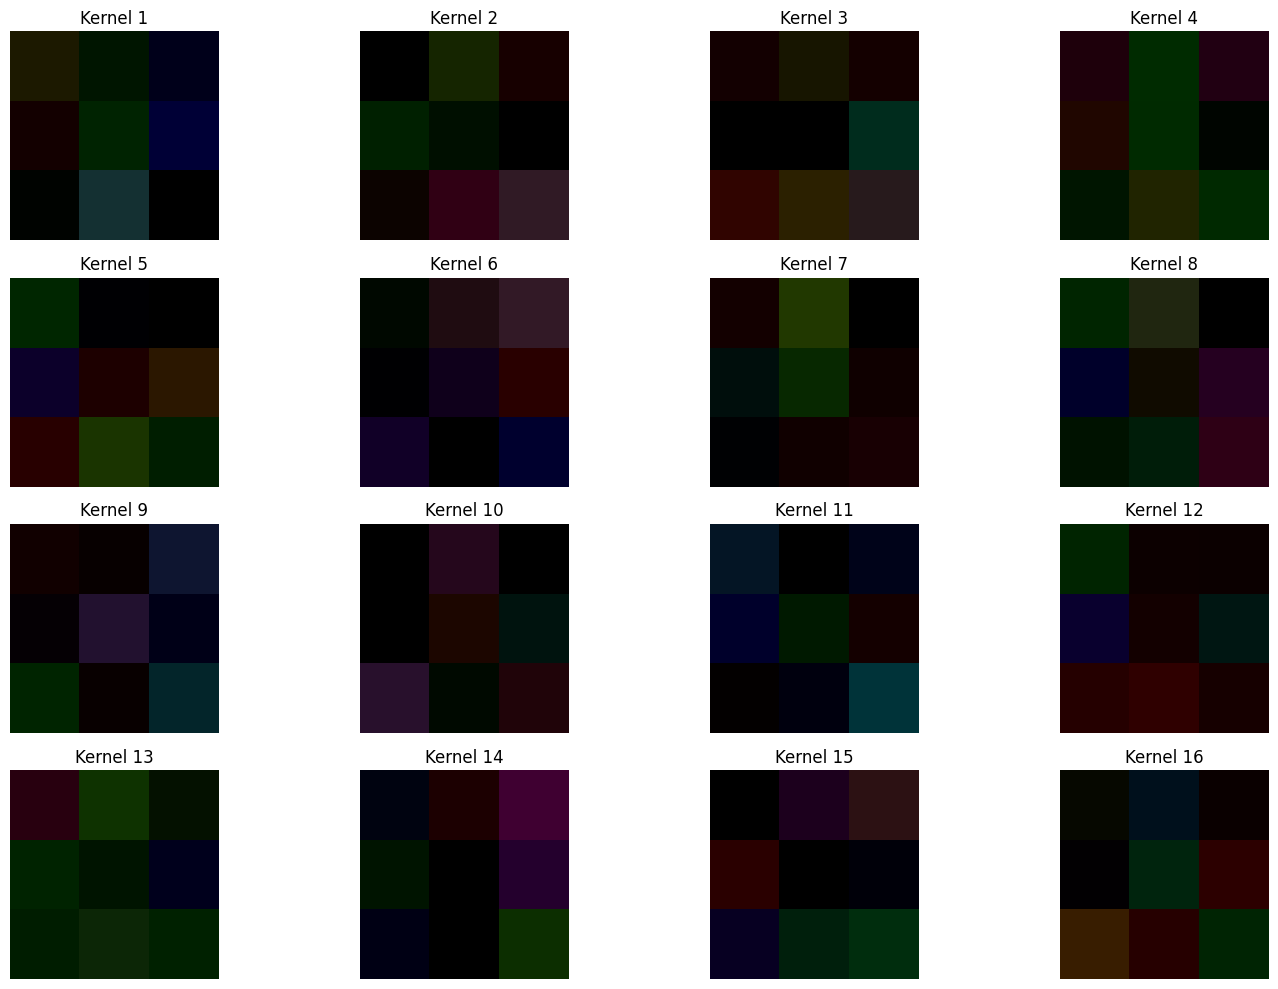

In [ ]:
import torch
import matplotlib.pyplot as plt

PATH = 'model_95.pth'

# Load the saved model
loaded_model = Net()  # Use the correct model class (Net) here
# loaded_model.load_state_dict(torch.load(PATH))
loaded_model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
loaded_model.eval()  # Set the model to evaluation mode

# Get the weights of the first convolutional layer
first_conv_layer_weights = loaded_model.conv1.weight.data

# Visualize the learned kernels in a grid
num_kernels = first_conv_layer_weights.shape[0]
rows = 4  # You can adjust the number of rows and columns based on the number of kernels
cols = num_kernels // rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
for i in range(rows):
    for j in range(cols):
        kernel = first_conv_layer_weights[i * cols + j].cpu().numpy()
        axes[i, j].imshow(kernel.transpose(1, 2, 0))  # Transpose dimensions for proper display
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Kernel {i * cols + j + 1}')

plt.tight_layout()
plt.show()


### **Class Activation Map (Heatmap)**

In [ ]:
# Define a hook to get the output of the last convolutional layer
activation = None
def get_activation(name):
    def hook(model, input, output):
        global activation
        activation = output.detach()
    return hook

# Attach the hook to the last convolutional layer
hook_handle = loaded_model.conv4.register_forward_hook(get_activation('conv4'))

# Choose an index for the image in the batch
index = 20  # Change this index based on which image you want to visualize

# Select the specific image from the batch
sample_image = test_loader.dataset[index][0].unsqueeze(0)

# Forward pass to get the model prediction and the activation map
with torch.no_grad():
    output = loaded_model(sample_image)
    _, predicted = torch.max(output, 1)
    activation_map = activation.squeeze().cpu().numpy()

# Detach the hook
hook_handle.remove()

activation_map.shape, output.shape

((128, 16, 16), torch.Size([1, 7]))

In [ ]:
# Upsample the activation map to the original image size
upsample = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


# Select the first channel of the activation map
activation_map_channel = activation_map[0]

# Normalize the activation map
activation_map_channel = (activation_map_channel - activation_map_channel.min()) / (activation_map_channel.max() - activation_map_channel.min())

# Convert the image and activation map_channel to NumPy arrays
image_np = sample_image[0].permute(1, 2, 0).cpu().numpy()
activation_map_channel_np = upsample(activation_map_channel).squeeze().numpy()

activation_map_channel.shape

(16, 16)

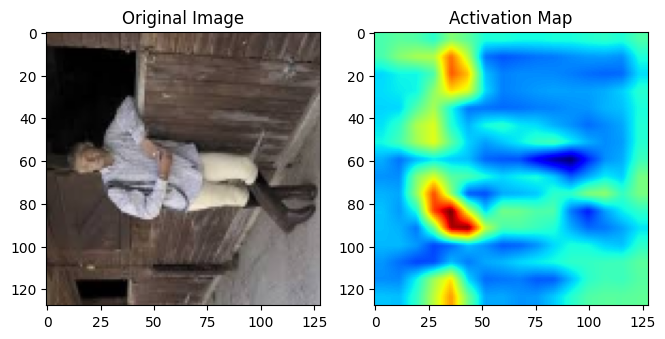

In [ ]:
# Display the original image, activation map, and CAM result
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(image_np)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(activation_map_channel_np, cmap='jet')
plt.title('Activation Map')

# plt.subplot(133)
# plt.imshow(cam_result_channel)
# plt.title('CAM Result')

plt.show()

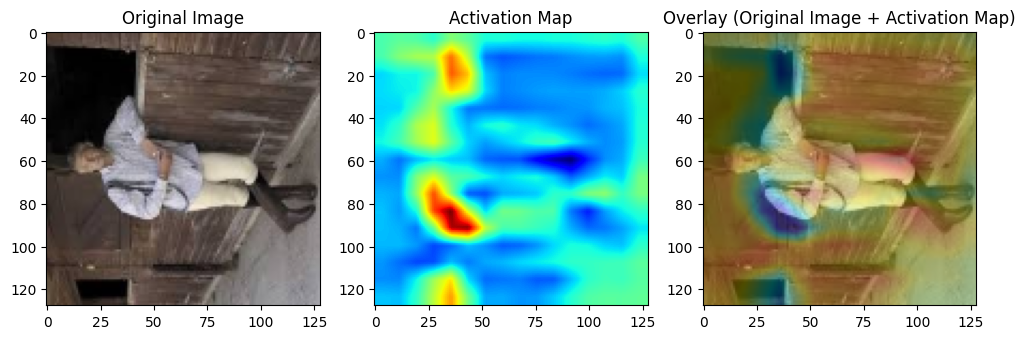

In [ ]:
# Convert the image to uint8 for visualization
image_np_uint8 = (image_np * 255).astype(np.uint8)

# Overlay the activation map_channel on the original image
heatmap_channel = cv2.applyColorMap(np.uint8(255 * activation_map_channel_np), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(image_np_uint8, 0.7, heatmap_channel, 0.3, 0)

# Display the original image, activation map_channel, and CAM result
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(image_np_uint8)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(activation_map_channel_np, cmap='jet')
plt.title('Activation Map')

plt.subplot(133)
plt.imshow(overlay)
plt.title('Overlay (Original Image + Activation Map)')

plt.show()


# **SVM with CNN**

In [ ]:
from sklearn import svm

# Instantiate the original CNN model and SVM classifier
model = Net()
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on', device)
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)
    val_loss = val(model, device, val_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)


Training on cpu
Epoch: 1
Training set: Average loss: 1.639228
Test set: Average loss: 1.323339, Accuracy: 305/540 (56%)

Validation set: Average loss: 1.379987, Accuracy: 293/542 (54%)

Epoch: 2
Training set: Average loss: 1.038462
Test set: Average loss: 0.910912, Accuracy: 356/540 (66%)

Validation set: Average loss: 0.973983, Accuracy: 331/542 (61%)

Epoch: 3
Training set: Average loss: 0.834125
Test set: Average loss: 0.785075, Accuracy: 377/540 (70%)

Validation set: Average loss: 0.850105, Accuracy: 366/542 (68%)

Epoch: 4
Training set: Average loss: 0.708529
Test set: Average loss: 0.687041, Accuracy: 393/540 (73%)

Validation set: Average loss: 0.718400, Accuracy: 399/542 (74%)

Epoch: 5
Training set: Average loss: 0.585130
Test set: Average loss: 0.580997, Accuracy: 419/540 (78%)

Validation set: Average loss: 0.613744, Accuracy: 411/542 (76%)

Epoch: 6
Training set: Average loss: 0.501978
Test set: Average loss: 0.534385, Accuracy: 431/540 (80%)

Validation set: Average loss:

In [ ]:
svm_model = model

In [ ]:
# Function to extract features from the CNN
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            # Extract features from the conv4 layer
            features.append(model.conv4(model.pool(F.relu(model.conv3(model.pool(F.relu(model.conv2(model.pool(F.relu(model.conv1(images)))))))))).detach().cpu())
            labels.append(targets)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    return features, labels



# Extract features from the convolutional layers for training, validation, and test sets
train_features, train_labels = extract_features(loaded_model, train_loader, device)
val_features, val_labels = extract_features(loaded_model, val_loader, device)
test_features, test_labels = extract_features(loaded_model, test_loader, device)

# Flatten the features
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

In [ ]:
# Train an SVM classifier
svm_classifier = svm.SVC()
svm_classifier.fit(train_features, train_labels)

# Evaluate the SVM on validation set
svm_predictions = svm_classifier.predict(val_features)

# Evaluate accuracy
accuracy = accuracy_score(val_labels, svm_predictions)
print(f"Validation Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation Accuracy: 0.8523985239852399


In [ ]:
# Evaluate the SVM on Test set
svm_predictions = svm_classifier.predict(test_features)

# Evaluate accuracy
accuracy = accuracy_score(test_labels, svm_predictions)
print(f"Testing Accuracy: {accuracy}")

Testing Accuracy: 0.8685185185185185


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Evaluate the SVM on Test set
svm_predictions = svm_classifier.predict(test_features)

# Calculate accuracy
accuracy = accuracy_score(test_labels, svm_predictions)
print(f"Testing Accuracy: {accuracy}")

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, svm_predictions, average='weighted')
recall = recall_score(test_labels, svm_predictions, average='weighted')
f1 = f1_score(test_labels, svm_predictions, average='weighted')

# Display classification report
class_report = classification_report(test_labels, svm_predictions)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Classification Report:")
print(class_report)

Testing Accuracy: 0.8685185185185185
Precision: 0.8726060278600417
Recall: 0.8685185185185185
F1 Score: 0.8678237761727426
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       114
           1       0.87      0.92      0.89       134
           2       0.71      0.86      0.77        64
           3       0.71      0.61      0.65        59
           4       0.98      1.00      0.99        49
           5       0.91      0.97      0.94        61
           6       0.96      0.78      0.86        59

    accuracy                           0.87       540
   macro avg       0.87      0.86      0.86       540
weighted avg       0.87      0.87      0.87       540



In [ ]:
# import matplotlib.pyplot as plt

# # Accuracy values for your models
# cnn_model = 0.946
# svm_model = 0.868

# # Bar chart
# models = ['Custom CNN Model', 'CNN + SVM on classification layer']
# accuracies = [cnn_model, svm_model]

# plt.bar(models, accuracies, color=['blue', 'green'])
# plt.ylim(0, 1)  # Set the y-axis limit based on the accuracy range (0 to 1)
# plt.title('Accuracy Comparison')
# plt.xlabel('Models')
# plt.ylabel('Accuracy')
# plt.show()


# **Report**

**Custom Model:**
- Accuracy: 95.0%
- Precision: 94.80%
- Recall: 94.63%
- F1 Score: 94.58%

**CNN+SVM Model:**
- Accuracy: 86.85%
- Precision: 87.26%
- Recall: 86.85%
- F1 Score: 86.78%

**Comparison:**
- The custom model outperforms the CNN+SVM model in terms of accuracy, precision, recall, and F1 score.
- The custom model achieved higher scores in all metrics, indicating superior performance on the evaluated task.
- Notably, the custom model demonstrated better capability in distinguishing between different classes, as reflected in higher precision, recall, and F1 score values across most classes.

